# How to invent words
Steve Martin

May 2024

This notebook ingests a word list and uses various approaches to invent words that seem plausible.

### 1. Import word list

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import string
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, GridSearchCV

In [2]:
with open('wordlist', 'r') as f:
    word_list_raw = f.read()

In [3]:
word_list = word_list_raw.split('\n')

In [4]:
word_list[:10]

['a',
 'a-horizon',
 'a-ok',
 'aardvark',
 'aardwolf',
 'ab',
 'aba',
 'abaca',
 'abacist',
 'aback']

### 2. Data cleaning

As we can see, some words have punctuation (and who knows what else) that aren't desirable. Let's see how frequently these undesirable characters arise and what we stand to lose by simply removing them. Additionally, I am going to remove words that are less than 3 letters.

In [5]:
len(word_list)

50349

In [6]:
word_list_clean = [w for w in word_list if w.isalpha()]

In [7]:
word_list_clean[:10]

['a',
 'aardvark',
 'aardwolf',
 'ab',
 'aba',
 'abaca',
 'abacist',
 'aback',
 'abactinal',
 'abacus']

In [8]:
len(word_list_clean)

48641

In [9]:
word_list_clean = [w for w in word_list_clean if len(w) > 2]

In [10]:
len(word_list_clean)

48412

In [11]:
len(word_list_clean) / len(word_list)

0.9615285308546346

### 3. Success metrics

I'm defining the effectiveness of a "word generator" as a function that can generate words that appear plausibly English, but are not actually part of the language. This is difficult to quantify, but the metric I'm going to use for success is the percent of randomly generated words that are in fact real.

The logic here is that all word generators will occasionally produce a real English word by accident, but better generators will do this more often than worse ones. This of course requires some honesty: I could easily hit 100% on this metric by choosing a random word from the dictionary. But as long as I'm honest, this metric is probably fine for now.

In [12]:
def print_stats(frac, matches, new, n=10):
    print(f"Match fraction: {frac}\n\n{n} examples of existing words: {matches[:n]}\n\n{n} examples of new words: {new[:n]}")

    lengths = [len(s) for s in matches]
    longest_index = lengths.index(max(lengths))
    longest_string = matches[longest_index]
    
    print(f"Longest existing word is : {longest_string}")


class WordGenBase:
    """
    Base class for letter-by-letter word generators

    Parameters
    ----------
    wordlist: list
        List of dictionary words used for training and evaluation
    """
    _ALPHABET = list(string.ascii_lowercase)
    
    def __init__(self, wordlist):
        self.wordlist = wordlist
        self.eow_prob = self._get_eow_prob()

    def _get_eow_prob(self):
        avg_len = np.mean([len(w) for w in self.wordlist])
        return 1 / avg_len

    def next_letter(self, word):
        pass

    def generate(self):
        """
        Generate a word

        Returns
        -------
        word: str
            Generated word
        """
        word = ''
        while not word.endswith('_'):
            word += self.next_letter(word)
        return word[:-1]

    def evaluate(self, n=1000):
        """
        Evaluates match fraction of generated words against word list

        Parameters
        ----------
        n: int
            Number of words to be generated in evaluation

        Returns
        -------
        matched_fraction: float
            Fraction of generated words that matched a word in self.wordlist
        matched_words: list
            All generated words that matched a word in self.wordlist
        new_words: list
            All generated words that did not match a word in self.wordlist       
        """
        matched_words = []
        new_words = []
        for i in range(n):
            w = self.generate()
            if w in self.wordlist:
                matched_words.append(w)
            else:
                new_words.append(w)
        matched_fraction = len(matched_words) / n
        return matched_fraction, matched_words, new_words

### 4. Generators

Now we come to actually making word generators. In the following subsections, I will build out 4 different word generators and evaluate effectiveness:

- Random
- Single letter frequency
- Next letter likelihood (NLL)
- Overpowered ML approach

#### 4a. Random Generator

Here, we establish a baseline by making a generator that randomly choosed between any of the 26 letters, and ends the word with probability 1 / (average dictionary word length).

In [13]:
class WordGenRandom(WordGenBase):
    def __init__(self, wordlist):
        super().__init__(wordlist)
        
    def next_letter(self, word):
        r = np.random.random()
        if len(word) > 2 and r < self.eow_prob:
            return '_'
        return np.random.choice(self._ALPHABET)

In [14]:
gen = WordGenRandom(word_list_clean)
frac, matches, new = gen.evaluate()

In [15]:
print_stats(frac, matches, new)

Match fraction: 0.006

10 examples of existing words: ['off', 'rho', 'kob', 'sif', 'jet', 'str']

10 examples of new words: ['jxh', 'tizyvttqu', 'frki', 'xjipcxqijojfncbskhethbaryifpdqaixktbx', 'urozwkbuckcafnwliiyyinubhhfbarc', 'drehk', 'wdknuhqseti', 'spf', 'oxh', 'hblbmkhdhouhi']
Longest existing word is : off


#### 4b. Single letter frequency generator

Find the frequency of each letter and use this to inform the next letter guess.

In [16]:
letter_count = {}

for w in word_list_clean:
    for c in w:
        if c not in letter_count:
            letter_count[c] = 1
        else:
            letter_count[c] += 1

In [17]:
letter_count = dict(sorted(letter_count.items()))

In [18]:
letter_count

{'a': 38531,
 'b': 9139,
 'c': 20676,
 'd': 15395,
 'e': 43614,
 'f': 5966,
 'g': 9098,
 'h': 10708,
 'i': 36583,
 'j': 883,
 'k': 3405,
 'l': 23815,
 'm': 11389,
 'n': 27974,
 'o': 26823,
 'p': 9885,
 'q': 607,
 'r': 26492,
 's': 27395,
 't': 25623,
 'u': 15706,
 'v': 4308,
 'w': 3241,
 'x': 1430,
 'y': 8053,
 'z': 1186}

In [19]:
letter_sum = sum(letter_count.values())

In [20]:
letter_sum

407925

In [21]:
letter_count_df = pd.DataFrame({k: [v] for k, v in letter_count.items()})

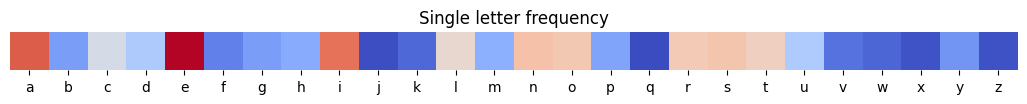

In [22]:
plt.figure(figsize=(13, 0.5))
heatmap = sns.heatmap(letter_count_df, 
                      annot=False, 
                      cmap='coolwarm', 
                      fmt='g', 
                      yticklabels=False,
                      cbar=False)
plt.title('Single letter frequency')
plt.show()

In [23]:
class WordGenSingleFreq(WordGenBase):
    def __init__(self, wordlist):
        super().__init__(wordlist)
        self.letter_frequencies = self._get_letter_frequencies()

    def _get_letter_frequencies(self):
        letter_count = {l: 0 for l in self._ALPHABET}

        for w in self.wordlist:
            for c in w:
                letter_count[c] += 1

        letter_total = np.sum(list(letter_count.values()))
        letter_frequencies = [c / letter_total for c in letter_count.values()]
        return letter_frequencies
        
    def next_letter(self, word):
        r = np.random.random()
        if len(word) > 2 and r < self.eow_prob:
            return '_'       
        
        return np.random.choice(self._ALPHABET, p=self.letter_frequencies)

In [24]:
gen = WordGenSingleFreq(word_list_clean)
frac, matches, new = gen.evaluate()

In [25]:
print_stats(frac, matches, new)

Match fraction: 0.015

10 examples of existing words: ['ene', 'etc', 'eau', 'ses', 'din', 'als', 'sua', 'sat', 'ace', 'rit']

10 examples of new words: ['srsekidsdlsiad', 'rienagsorobzusoendba', 'srxayb', 'laiavvdeieahant', 'mavnclholcntrpol', 'eebrirhhihbhsitrs', 'riynolahsrirsn', 'nein', 'cro', 'aaparsrh']
Longest existing word is : ene


#### 4c. Next letter likelihood

Here, we use the likelihood for the next letter given the prior letter.

In [26]:
double_letter_count = {l: [0] * 27 for l in list(letter_count.keys()) + ['_']}
double_letter_count['index'] = list(letter_count.keys()) + ['_']

for w in word_list_clean:
    c1 = '_'
    c2 = ord(w[0]) - 97
    double_letter_count[c1][c2] += 1
    for i in range(len(w)):
        c1 = w[i]
        if i == len(w) - 1:
            c2 = 26
        else:
            c2 = ord(w[i + 1]) - 97
        
        double_letter_count[c1][c2] += 1

double_letter_df = pd.DataFrame(double_letter_count)
double_letter_df.set_index('index', inplace=True)

In [27]:
double_letter_df

,a,b,c,d,e,f,g,h,i,j,...,r,s,t,u,v,w,x,y,z,_
index,,,,,,,,,,,,,,,,,,,,,
a,27,1429,3077,1522,2166,718,1013,1604,2542,212,...,3543,1308,2176,460,734,639,122,269,273,5412
b,1622,224,6,54,370,5,28,40,651,0,...,379,72,68,528,0,44,1,54,4,3732
c,2584,23,342,28,1449,17,9,16,3490,0,...,612,1345,228,575,0,9,115,229,0,6708
d,1288,56,7,214,3511,11,19,25,1808,0,...,781,28,11,435,0,42,0,152,1,3801
e,1167,1245,2408,3141,833,735,1593,2232,963,153,...,3251,2398,4997,495,1978,534,120,218,400,2677
f,331,10,2,46,448,463,19,41,694,0,...,155,41,98,142,0,31,6,20,0,2515
g,1156,6,1,150,468,9,245,7,1010,0,...,423,30,28,355,1,7,1,99,2,918
h,152,17,2500,66,154,4,493,17,28,3,...,169,1591,1530,7,0,271,31,29,4,2157
i,905,1166,1501,2642,441,1009,885,1643,102,54,...,3863,2229,5675,499,1057,459,230,107,136,2778


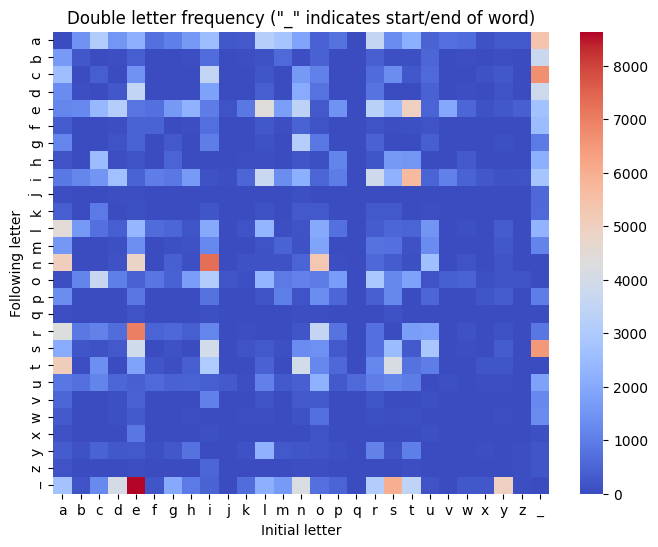

In [28]:
plt.figure(figsize=(8, 6))
sns.heatmap(double_letter_df, annot=False, cmap='coolwarm')
plt.title('Double letter frequency ("_" indicates start/end of word)')
plt.xlabel('Initial letter')
plt.ylabel('Following letter')
plt.show()

In [29]:
second_letter_prob = pd.DataFrame()
second_letter_prob['index'] = second_letter_prob.index
second_letter_prob.set_index('index', inplace=True)

for col in double_letter_df.columns:
    second_letter_prob[col] = double_letter_df[col]/double_letter_df[col].sum()

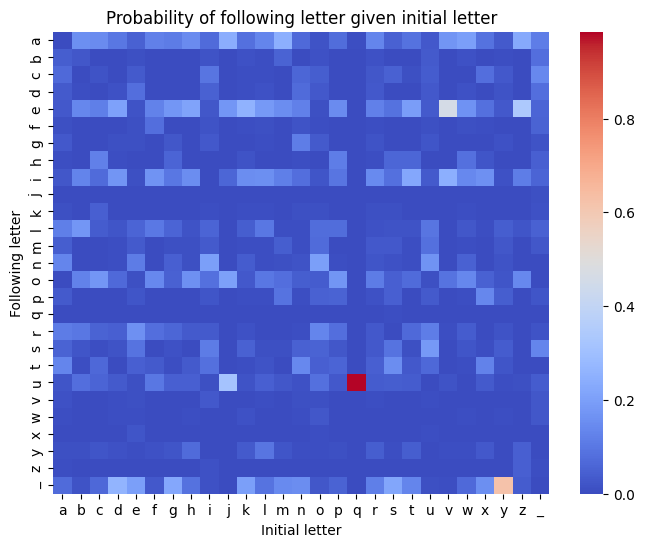

In [30]:
plt.figure(figsize=(8, 6))
sns.heatmap(second_letter_prob, annot=False, cmap='coolwarm')
plt.title('Probability of following letter given initial letter')
plt.xlabel('Initial letter')
plt.ylabel('Following letter')
plt.show()

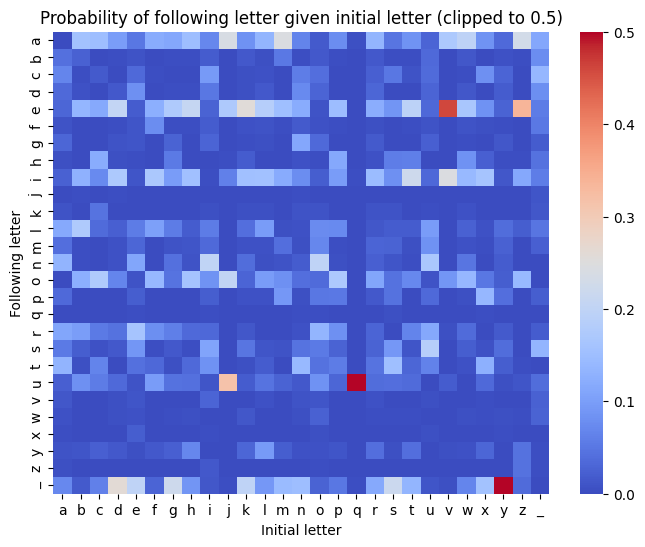

In [31]:
plt.figure(figsize=(8, 6))
sns.heatmap(second_letter_prob.clip(upper=0.5), annot=False, cmap='coolwarm')
plt.title('Probability of following letter given initial letter (clipped to 0.5)')
plt.xlabel('Initial letter')
plt.ylabel('Following letter')
plt.show()

In [32]:
class WordGenDoubleFreq(WordGenBase):
    def __init__(self, wordlist):
        super().__init__(wordlist)
        self.frequency_matrix = self._get_frequency_matrix()

    def _get_frequency_matrix(self):
        az_with_null = self._ALPHABET + ['_']
        double_letter_count = {l: [0] * 27 for l in az_with_null}
        double_letter_count['index'] = az_with_null

        for w in self.wordlist:
            c1 = '_'
            c2 = ord(w[0]) - 97
            double_letter_count[c1][c2] += 1
            for i in range(len(w)):
                c1 = w[i]
                if i == len(w) - 1:
                    c2 = 26
                else:
                    c2 = ord(w[i + 1]) - 97
                
                double_letter_count[c1][c2] += 1

        double_letter_df = pd.DataFrame(double_letter_count)
        double_letter_df.set_index('index', inplace=True)
        
        for col in double_letter_df.columns:
            double_letter_df[col] = double_letter_df[col]/double_letter_df[col].sum()
        
        return double_letter_df
        
    def next_letter_doub(self, word):
        if not word:
            last_letter = '_'
        else:
            last_letter = word[-1]

        probs = self.frequency_matrix[last_letter].tolist()

        next_letter = np.random.choice(self._ALPHABET + ['_'], p=probs)
        while next_letter == '_' and len(word) < 3:
            next_letter = np.random.choice(self._ALPHABET + ['_'], p=probs)
        
        return next_letter

    def next_letter(self, word):
        return self.next_letter_doub(word)

In [33]:
gen = WordGenDoubleFreq(word_list_clean)
frac, matches, new = gen.evaluate()

In [34]:
print_stats(frac, matches, new)

Match fraction: 0.072

10 examples of existing words: ['ate', 'der', 'coup', 'band', 'lily', 'une', 'sen', 'shy', 'bang', 'che']

10 examples of new words: ['spenghenancostrowovessertes', 'llingaly', 'ider', 'cllilylng', 'mieca', 'riburpenenwerphytpooiscutaroromer', 'veloraercan', 'sisog', 'sinarokyccedeaist', 'pid']
Longest existing word is : fabula


#### 4d. Overpowered ML predictor

Now I'm going to make an ML model that predicts the next letter (or end of word). The idea is to use XGBoostClassifier to calculate the probability of each sequential letter, and then randomly select the next letter based on these probabilities.

The following features will be used to train the model:
- Current length of word
- Previous 3 letters (one-hot encoded)

To ensure the model isn't overfit, I'm going to do an 80-20 train/test split of all words in the dictionary. I'll use 3-fold cross validation to tune hyperparameters, and then when doing the final prediction I will see what fraction of real words come from the test set vs. the training set -- if it's very far from a 80-20 split then we know that the model is overfit.

In [35]:
class WordGenXGB(WordGenDoubleFreq):
    _PARAM_GRID = {
        'max_depth': [3, 7],
        'learning_rate': [0.05, 0.2],
        'n_estimators': [50, 200],
        'gamma': [0, 0.2]
    }
    
    def __init__(self, wordlist):
        super().__init__(wordlist)
        self._classifier = None
        self.training_words = None
        self.test_words = None

    def _one_hot_letter(self, l, suffix):
        cols = self._ALPHABET + ['_']
        cols = [c + suffix for c in cols]
        one_hot_df = pd.DataFrame({c: [0] for c in cols})
        one_hot_df[l + suffix] = 1
        return one_hot_df

    def _encode_word(self, word):
        len_df = pd.DataFrame({'length': [len(word)]})

        l3, l2, l1 = (['_', '_', '_'] + [*word])[-3:]
        
        l1_df = self._one_hot_letter(l1, '1')
        l2_df = self._one_hot_letter(l2, '2')
        l3_df = self._one_hot_letter(l3, '3')
        
        X = pd.concat([len_df, l1_df, l2_df, l3_df], axis=1)
        return X

    def _get_feature_and_label(self, word):
        length = len(word)
        cutoff = np.random.randint(3, length + 1)
        word_trunc = word + '_'
        word_trunc = word_trunc[:cutoff]
        X_i = self._encode_word(word_trunc)
        y_i = (word + '_')[cutoff]
        return X_i, y_i

    def _split_train_test(self, test_size):
        self.training_words, self.test_words = train_test_split(self.wordlist, test_size=test_size)

    def get_features_and_labels(self):
        X = pd.DataFrame()
        y = []
        for word in self.training_words:
            X_i, y_i = self._get_feature_and_label(word)
            X = pd.concat([X, X_i])
            if y_i == '_':
                y += [26]
            else:
                y += [ord(y_i) - 97]
            
        return X, pd.Series(y)

    def train_classifier(self, test_size=0.2, n_splits=3):
        print("Performing train/test split...")
        self._split_train_test(test_size)

        print("Getting features and labels...")
        X, y = self.get_features_and_labels()

        print("Initializing classifier, KFold, and GridSearchCV...")
        xgb = XGBClassifier(objective='multi:softmax', num_class=27)
        kf = KFold(n_splits=n_splits)
        grid_search = GridSearchCV(xgb, self._PARAM_GRID, cv=kf)

        print("Fitting grid search and finding best params...")
        grid_search.fit(X, y)
        best_params = grid_search.best_params_

        print(f"Fitting classifier with best params: {best_params}...")
        self._classifier = XGBClassifier(objective='multi:softmax', num_class=27, **best_params).fit(X, y)
        
        
    def next_letter(self, word):
        X = self._encode_word(word)
        probs = self._classifier.predict_proba(X)[0]

        next_letter = np.random.choice(self._ALPHABET + ['_'], p=probs)

        while next_letter == '_' and len(word) < 3:
            next_letter = np.random.choice(self._ALPHABET + ['_'], p=probs)
        
        return next_letter

In [36]:
gen = WordGenXGB(word_list_clean)
gen.train_classifier()

Performing train/test split...
Getting features and labels...
Initializing classifier, KFold, and GridSearchCV...
Fitting grid search and finding best params...
Fitting classifier with best params: {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}...


In [37]:
frac, matches, new = gen.evaluate()

In [38]:
print_stats(frac, matches, new)

Match fraction: 0.056

10 examples of existing words: ['mara', 'aloe', 'lose', 'dingo', 'kip', 'ide', 'use', 'esse', 'lek', 'ills']

10 examples of new words: ['opsabine', 'sirinoded', 'antinulation', 'denum', 'instarine', 'verboxic', 'noss', 'igwornal', 'naledent', 'sedactable']
Longest existing word is : eristic


In [39]:
n_matches = len(matches)
n_train_matches = len([w for w in matches if w in gen.training_words])
n_test_matches = len([w for w in matches if w in gen.test_words])
train_fraction = n_train_matches / n_matches
test_fraction = n_test_matches / n_matches
print(f"Fraction of matches in training set: {train_fraction}\n\nFraction of matches in test set: {test_fraction}")

Fraction of matches in training set: 0.8392857142857143

Fraction of matches in test set: 0.16071428571428573
